# Initialization

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [2]:
train=pd.read_csv('../data/data.csv.zip', compression='zip', index_col=1)
train=train.drop(columns=['Unnamed: 0'])

# Data cleaning

In [3]:
train.columns = train.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
train=train.drop(columns=['photo', 'flag', 'club_logo'])

train['value_unit'] = train['value'].str[-1]
train['nvalue'] = np.where(train['value_unit'] == '0', 0,
                          train['value'].str[1:-1].replace(r'[a-zA-Z]',''))
train['nvalue'] = train['nvalue'].astype(float)
train['nvalue'] = np.where(train['value_unit'] == 'M', train['nvalue'], train['nvalue'] / 1000)

train['wage_unit'] = train['wage'].str[-1]
train['nwage'] = np.where(train['wage_unit'] == '0', 0,
                          train['wage'].str[1:-1].replace(r'[a-zA-Z]',''))
train['nwage'] = train['nwage'].astype(float)
train['nwage'] = np.where(train['wage_unit'] == 'K', train['nwage'], train['nwage'] * 1000)


# Features selection

## Drop missing values.

In [4]:
def drop_missing_values(train):
    df = train.dropna(subset=['aggression', 'overall', 'age', 'potential', 
                        'international_reputation',
                        'weak_foot', 'skill_moves', 'crossing', 'finishing', 'headingaccuracy', 
                        'shortpassing', 'volleys', 'dribbling', 'curve', 'fkaccuracy', 'longpassing',
                        'ballcontrol', 'acceleration', 'sprintspeed',
                        'agility', 'reactions', 'balance', 'shotpower', 'jumping', 'stamina', 
                        'strength',
                        'longshots', 'aggression', 'interceptions', 'positioning', 'vision', 
                        'penalties',
                        'composure', 'marking', 'standingtackle', 'slidingtackle', 'gkdiving', 
                        'gkhandling', 'gkkicking', 'gkpositioning', 'gkreflexes'])
    return df


In [5]:
df = drop_missing_values(train)

In [6]:
X = df[['aggression', 'age', 'potential', 'international_reputation',
            'weak_foot', 'skill_moves', 'crossing', 'finishing', 'headingaccuracy', 
            'shortpassing', 'volleys', 'dribbling', 'curve', 'fkaccuracy', 'longpassing',
            'ballcontrol', 'acceleration', 'sprintspeed',
            'agility', 'reactions', 'balance', 'shotpower', 'jumping', 'stamina', 'strength',
            'longshots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
            'composure', 'marking', 'standingtackle', 'slidingtackle', 'gkdiving', 
            'gkhandling', 'gkkicking', 'gkpositioning', 'gkreflexes']]
y = df.overall

# Define Models

In [7]:
models = []
models.append(('LR', linear_model.LinearRegression()))
models.append(('BR', linear_model.BayesianRidge(n_iter=1000)))
models.append(('Huber', linear_model.HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, 
                                                    max_iter=100, tol=1e-05, warm_start=False)))
models.append(('LarsCV', linear_model.LarsCV(max_iter=1000, eps=1.35, cv=10)))
models.append(('LassoCV', linear_model.LassoCV(max_iter=1000, cv=5)))
models.append(('RF', ensemble.RandomForestRegressor(n_estimators=10)))

# Model fitting and prediction

## Using cross validation

In [8]:
def cv_fit_and_predict(models, X, y):
    results = []
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
    for name, model in models:
        model.fit(train_X, train_y)
        y_pred = model.predict(val_X)
        score = cross_val_score(model, X, y, cv=10)
        print('Model {0} score: {1:.4f} and std dev: {2:.4f}'.format(name, score.mean(), score.std()))
        # The coefficients
        # print('Coefficients: \n', model.coef_)
        # The mean squared error
        print("Mean squared error: %.4f"
              % mean_squared_error(val_y, y_pred))
        print("Mean absolute error: %.4f" %mean_absolute_error(val_y, y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.4f' % r2_score(val_y, y_pred))
        # Regression score 
        # print('Regression score: %.4f' % model.score(X, y))
        results.append((name, score, r2_score(val_y, y_pred)))
        try:
            i
        except NameError:
            i=score.mean()-1        
        if score.mean() > i :
            imodel=model
            i=score.mean()

    print("Done")
    return results


In [9]:
results = cv_fit_and_predict(models, X, y)

Model LR score: -5.0360 and std dev: 3.5004
Mean squared error: 3.4297
Mean absolute error: 1.4506
Variance score: 0.9274
Model BR score: -5.0340 and std dev: 3.5073
Mean squared error: 3.4303
Mean absolute error: 1.4506
Variance score: 0.9274
Model Huber score: -5.6204 and std dev: 3.6732
Mean squared error: 4.1033
Mean absolute error: 1.5875
Variance score: 0.9131
Model LarsCV score: -8.0375 and std dev: 2.8204
Mean squared error: 7.3785
Mean absolute error: 2.1449
Variance score: 0.8438
Model LassoCV score: -5.0982 and std dev: 3.6074
Mean squared error: 3.4773
Mean absolute error: 1.4607
Variance score: 0.9264
Model RF score: -3.4342 and std dev: 1.3031
Mean squared error: 1.4449
Mean absolute error: 0.8204
Variance score: 0.9694
Done


# Validation and Results

In [10]:
def model_validation(results):
    fig, ax = plt.subplots()
    ax.boxplot(results[:,1])
    ax.set_xticklabels(results[:,0])
    ax.set_title('Model CV score')
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.bar(results[:,0], results[:,2])
    plt.xlabel('Models')
    plt.ylabel('Var score')
    plt.title('Models variance score')
    plt.show()
    
    return 0

In [11]:
results=np.array(results)

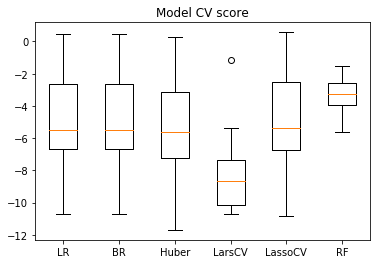

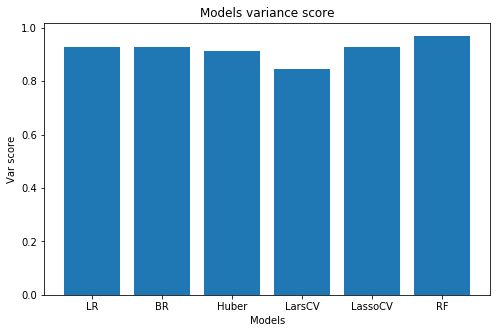

In [12]:
status = model_validation(results)